In [1]:
# svm_mnist_tsne.py
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, metrics
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix

# ----------------------------
# 中文字体设置（Windows）
# ----------------------------
plt.rcParams["font.family"] = ["SimSun", "SimHei", "Microsoft YaHei"]
plt.rcParams["axes.unicode_minus"] = False

# ========================
# 1. 数据加载与预处理
# ========================
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# 转成 numpy
X_train = train_dataset.data.numpy().reshape(-1, 28*28) / 255.0
y_train = train_dataset.targets.numpy()
X_test = test_dataset.data.numpy().reshape(-1, 28*28) / 255.0
y_test = test_dataset.targets.numpy()

# 取部分样本加快计算
n_samples = 10000
X_train, y_train = X_train[:n_samples], y_train[:n_samples]
X_test, y_test = X_test[:4000], y_test[:4000]  # 测试集也减小


In [2]:
# ========================
# 2. 原始784维 SVM
# ========================
print("训练 SVM（原始784维）...")
clf_raw = svm.SVC(kernel='rbf', gamma=0.05)
clf_raw.fit(X_train, y_train)
y_pred_raw = clf_raw.predict(X_test)
acc_raw = metrics.accuracy_score(y_test, y_pred_raw)
print(f"原始784维准确率：{acc_raw*100:.2f}%")

# ========================
# 3. PCA→t-SNE 2D 降维
# ========================
print("执行 PCA(100维) → t-SNE(2D) ...")
pca_100 = PCA(n_components=100, random_state=42)
X_train_pca100 = pca_100.fit_transform(X_train)
X_test_pca100 = pca_100.transform(X_test)

tsne_2d = TSNE(n_components=2, random_state=42, init='pca', perplexity=30)
X_train_tsne2 = tsne_2d.fit_transform(X_train_pca100)
X_test_tsne2 = tsne_2d.fit_transform(X_test_pca100)

print("训练 SVM（t-SNE 2D）...")
clf_2d = svm.SVC(kernel='rbf', gamma='auto')
clf_2d.fit(X_train_tsne2, y_train)
y_pred_2d = clf_2d.predict(X_test_tsne2)
acc_2d = metrics.accuracy_score(y_test, y_pred_2d)
print(f"t-SNE 2D 准确率：{acc_2d*100:.2f}%")

# ========================
# 4. PCA→t-SNE 3D 降维
# ========================
print("执行 PCA(100维) → t-SNE(3D) ...")
tsne_3d = TSNE(n_components=3, random_state=42, init='pca', perplexity=30)
X_train_tsne3 = tsne_3d.fit_transform(X_train_pca100)
X_test_tsne3 = tsne_3d.fit_transform(X_test_pca100)

print("训练 SVM（t-SNE 3D）...")
clf_3d = svm.SVC(kernel='rbf', gamma='auto')
clf_3d.fit(X_train_tsne3, y_train)
y_pred_3d = clf_3d.predict(X_test_tsne3)
acc_3d = metrics.accuracy_score(y_test, y_pred_3d)
print(f"t-SNE 3D 准确率：{acc_3d*100:.2f}%")

训练 SVM（原始784维）...
原始784维准确率：95.33%
执行 PCA(100维) → t-SNE(2D) ...
训练 SVM（t-SNE 2D）...
t-SNE 2D 准确率：44.42%
执行 PCA(100维) → t-SNE(3D) ...
训练 SVM（t-SNE 3D）...
t-SNE 3D 准确率：55.20%


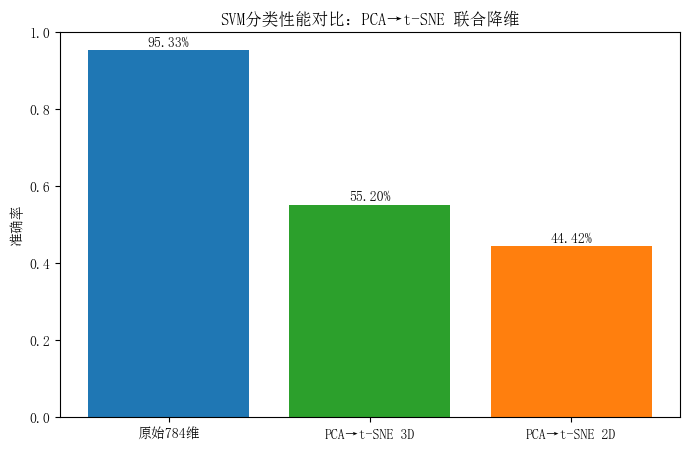

In [3]:
# ========================
# 5. 准确率对比图
# ========================
plt.figure(figsize=(8, 5))
methods = ["原始784维", "PCA→t-SNE 3D", "PCA→t-SNE 2D"]
accuracies = [acc_raw, acc_3d, acc_2d]
plt.bar(methods, accuracies, color=["#1f77b4", "#2ca02c", "#ff7f0e"])
plt.title("SVM分类性能对比：PCA→t-SNE 联合降维")
plt.ylabel("准确率")
plt.ylim(0, 1)
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.01, f"{v*100:.2f}%", ha='center', fontsize=10)
plt.show()

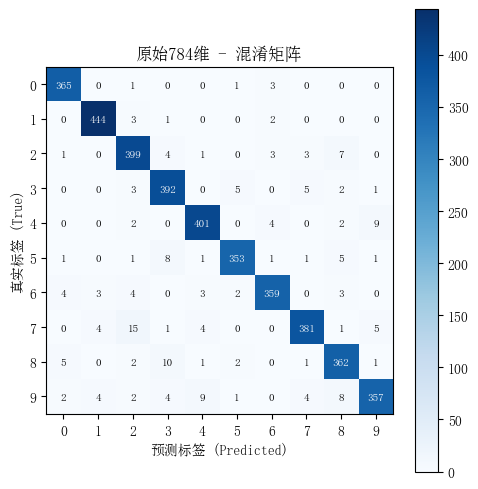

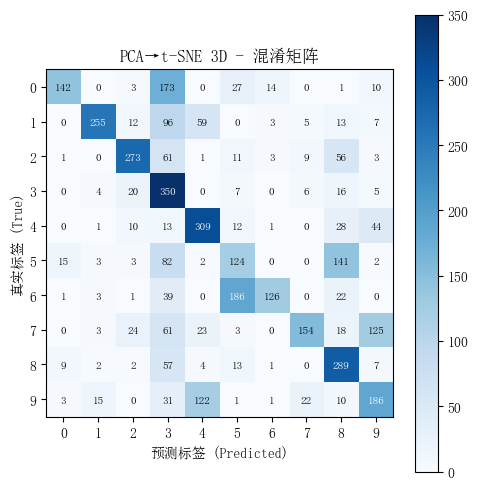

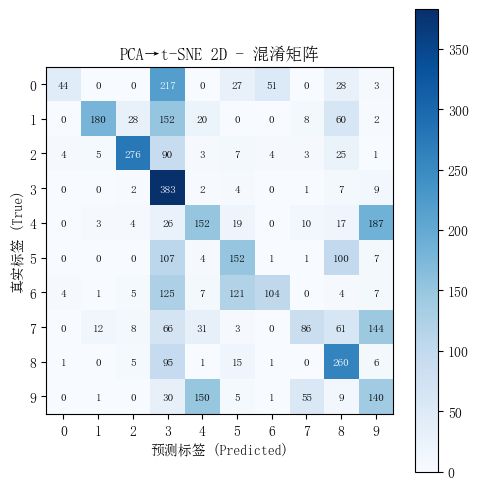

In [4]:
# ========================
# 6. 混淆矩阵函数
# ========================
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,5))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    plt.xlabel("预测标签 (Predicted)")
    plt.ylabel("真实标签 (True)")
    tick_marks = np.arange(10)
    plt.xticks(tick_marks, tick_marks)
    plt.yticks(tick_marks, tick_marks)
    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black",
                     fontsize=8)
    plt.tight_layout()
    plt.show()

# ========================
# 7. 各模型混淆矩阵
# ========================
plot_confusion_matrix(y_test, y_pred_raw, "原始784维 - 混淆矩阵")
plot_confusion_matrix(y_test, y_pred_3d, "PCA→t-SNE 3D - 混淆矩阵")
plot_confusion_matrix(y_test, y_pred_2d, "PCA→t-SNE 2D - 混淆矩阵")